# 1 Установка библиотек

In [131]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os

# 2 Определение гиперпараметров

In [132]:
#входной размер изображений соответтсвует модели EfficiennetBo
IMG_SIZE = (224, 224)
TRAINING_DIR = "./data/train/"
VALIDATION_DIR = "./data/validation/"
CLASSES = ['bmw_x5', 'land_cruiser', 'qashqai', 'solyaris', 'vaz_2110']

In [133]:
# cоздадим callback и место записи логитов
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Создаcоздадим callback  для чекпоинтов, чтобы сохранить модель для последующего использования 
CHECKPOINT_PATH = "./checkpoint/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True, # сохраним только веса модели
                                                         monitor="val_accuracy", # сохранить веса модели, которые обеспечивают наилучшую точность валидации
                                                         save_best_only=True)

# 3 Загрузка данных

ImageDataGenerator...
Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...


In [134]:
# Загружаем набор изображений с помощью ImageDataGenerator с применением аугментации для тренировочного набора
training_datagen = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                target_size=IMG_SIZE,
                                                                class_mode='categorical',
                                                                shuffle=False,batch_size=32)

Found 130 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


# 4 Создание  и обучение модели

In [135]:
# Загрузим модель EfficientNetB0, предварительно обученную на наборе Imagenet,
# исключив полносвязный верхинй слой и заморозив для обучения остальные 
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

In [136]:
# Можем посмотреть состав модели и убедиться, что слои заморожены, а выход модели имеет размерность (None, 7, 7, 1280)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [137]:
# Настройка архитектуры модели с обучаемыми верхними слоями
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs, training=False) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # объединить результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [12]:
# Теперь наша модель выглядит так, обучаемых параметров получается в районе 6,5 тыс
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

In [13]:
# Компиляция
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                                           epochs=40, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/40


2022-03-31 19:26:04.990041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-03-31 19:26:05.629017: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5/5 [==============================] - 9s 794ms/step - loss: 1.7164 - accuracy: 0.2231 - val_loss: 1.5147 - val_accuracy: 0.3556
Epoch 2/40
5/5 [==============================] - 2s 531ms/step - loss: 1.6353 - accuracy: 0.2692 - val_loss: 1.4182 - val_accuracy: 0.4667
Epoch 3/40
5/5 [==============================] - 2s 526ms/step - loss: 1.4671 - accuracy: 0.3538 - val_loss: 1.3376 - val_accuracy: 0.4889
Epoch 4/40
5/5 [==============================] - 2s 473ms/step - loss: 1.4741 - accuracy: 0.3538 - val_loss: 1.2638 - val_accuracy: 0.6667
Epoch 5/40
5/5 [==============================] - 2s 445ms/step - loss: 1.3167 - accuracy: 0.4692 - val_loss: 1.1993 - val_accuracy: 0.6667
Epoch 6/40
5/5 [==============================] - 2s 524ms/step - loss: 1.2229 - accuracy: 0.5308 - val_loss: 1.1366 - val_accuracy: 0.7111
Epoch 7/40
5/5 [==============================] - 2s 449ms/step - loss: 1.1528 - accuracy: 0.5615 - val_loss: 1.0828 - val_accuracy: 0.7111
Epoch 8/40
5/5 [===============

In [14]:
# Загрузим веса модели с лучшими показателями val_accuracy так
model.load_weights(CHECKPOINT_PATH)

In [15]:
# Оценка модели на валидационном наборе данных
results_feature_extraction_model = model.evaluate(validation_generator)
results_feature_extraction_model

2/2 [==============================] - 0s 28ms/step - loss: 0.5713 - accuracy: 0.9111


[0.5713227391242981, 0.9111111164093018]

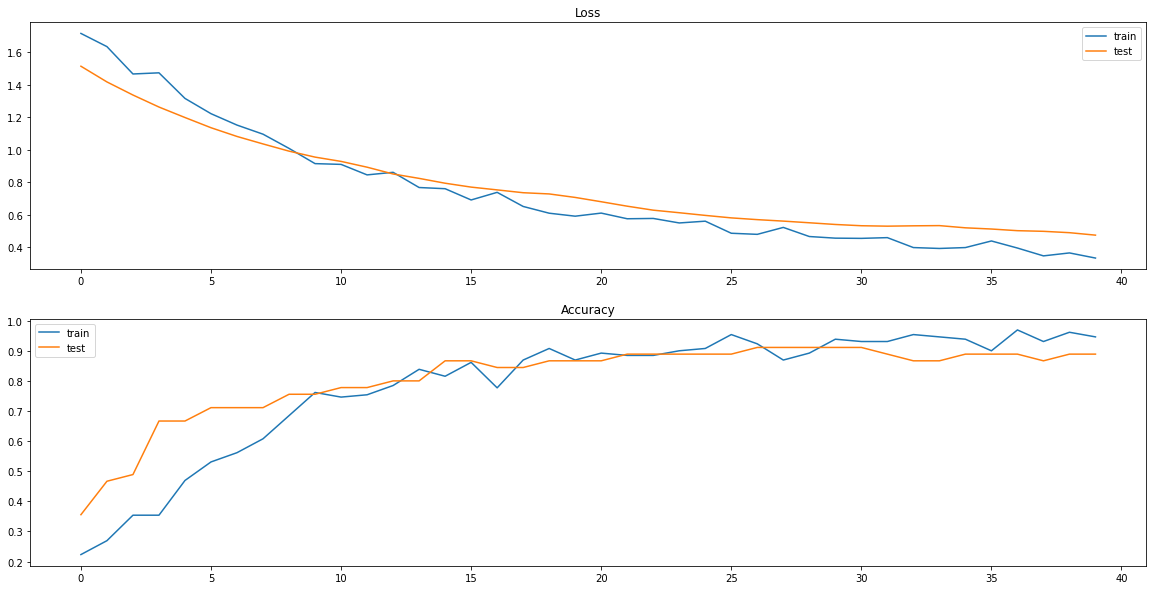

In [16]:
# График потерь во время обучения
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# График точности во время обучения
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Результаты достаточно неплохие, accuracy выходит на плато  в районе 0,85-0,9, так же можно выделить 
незначительное переобучнение, но мы хотим лучших результатов по этому переходим дальше

# 5 Тонкая настройка

In [138]:
# Оставим замороженными все слои кроме последних 10, их мы попытаемся обучить вместе с нашей моделью
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [139]:
# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_unfreez = tf.keras.Model(inputs, outputs)

In [140]:
# Вывод модели показывает, что количество обучаемых параметров выросло с 6,5 до 900 тыс. 
# за счет разморозки слоев efficientnetb0
model_unfreez.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
___________________________________________

In [141]:

# Compile
model_unfreez.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_unfreez = model_unfreez.fit(train_generator,
                                           epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
5/5 [==============================] - 6s 740ms/step - loss: 1.4737 - accuracy: 0.3692 - val_loss: 1.0528 - val_accuracy: 0.5556
Epoch 2/30
5/5 [==============================] - 2s 482ms/step - loss: 0.8364 - accuracy: 0.7538 - val_loss: 0.8199 - val_accuracy: 0.6889
Epoch 3/30
5/5 [==============================] - 2s 483ms/step - loss: 0.4719 - accuracy: 0.8692 - val_loss: 0.6340 - val_accuracy: 0.7778
Epoch 4/30
5/5 [==============================] - 2s 442ms/step - loss: 0.3235 - accuracy: 0.9538 - val_loss: 0.4658 - val_accuracy: 0.7333
Epoch 5/30
5/5 [==============================] - 2s 464ms/step - loss: 0.2564 - accuracy: 0.9385 - val_loss: 0.3790 - val_accuracy: 0.8444
Epoch 6/30
5/5 [==============================] - 2s 454ms/step - loss: 0.1635 - accuracy: 0.9923 - val_loss: 0.4702 - val_accuracy: 0.8222
Epoch 7/30
5/5 [==============================] - 2s 452ms/step - loss: 0.1586 - accuracy: 0.9692 - val_loss: 0.5468 - val_accuracy: 0.7778
Epoch 8/30
5/5 [====

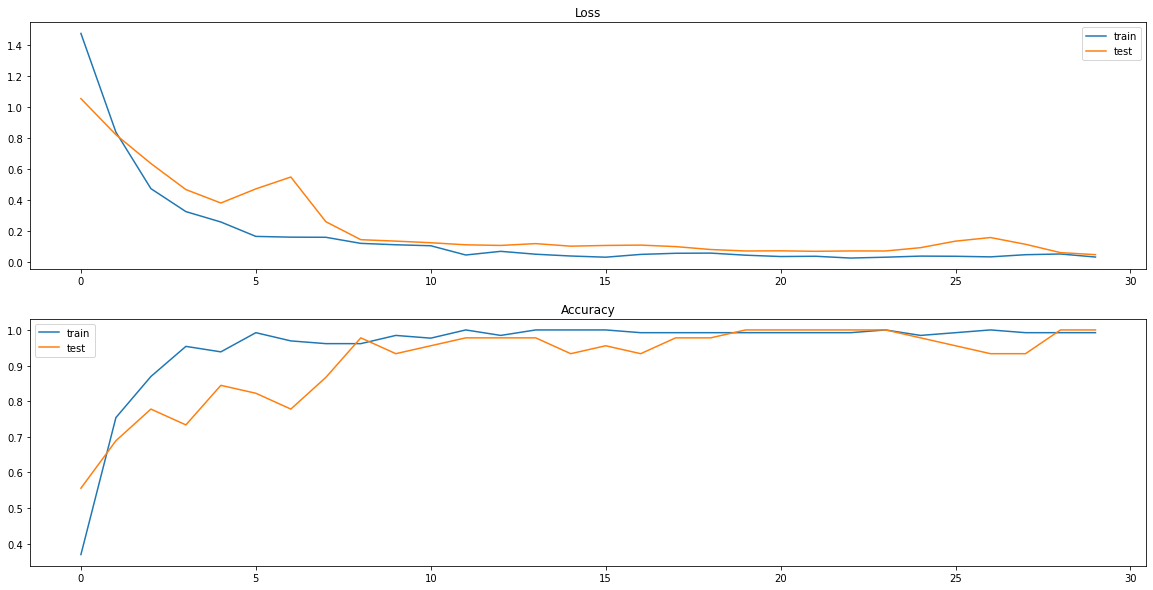

In [142]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history_unfreez.history['loss'], label='train')
plt.plot(history_unfreez.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_unfreez.history['accuracy'], label='train')
plt.plot(history_unfreez.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Точность равную 1 мы получили примерно через 20 эпох обучения, далее мы наблюдаем  незначительные колебания в районе единицы, переобучения практически избежали 


In [143]:
#загрузим веса модели с наилучшими параметрами val_accuracy за период обучения
model_unfreez.load_weights(CHECKPOINT_PATH)

In [144]:
# Оценка модели на валидационном наборе данных
results_all_fine_tune = model_unfreez.evaluate(validation_generator)
results_all_fine_tune

2/2 [==============================] - 0s 28ms/step - loss: 0.0694 - accuracy: 1.0000


[0.06935553252696991, 1.0]

# 6 Оценка модели

In [ ]:
# !tensorboard --logdir logs/fit

В tensorboard так же можно смотреть на графики обучения, причем совмещать несколько обучений за раз
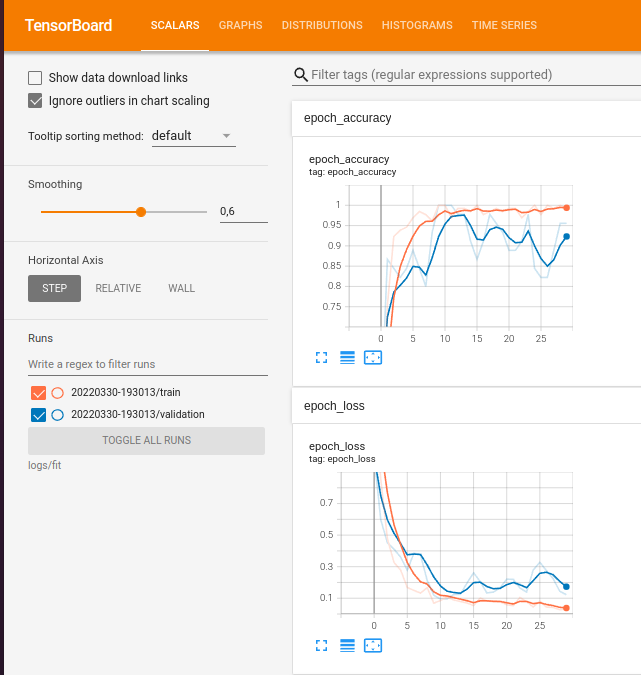

В tensorboard буквально можно наблюдать как обучались элементы вашей модели на каждой эпохе, это очень может пригодиться при 
качественной оценке каждого слоя модели

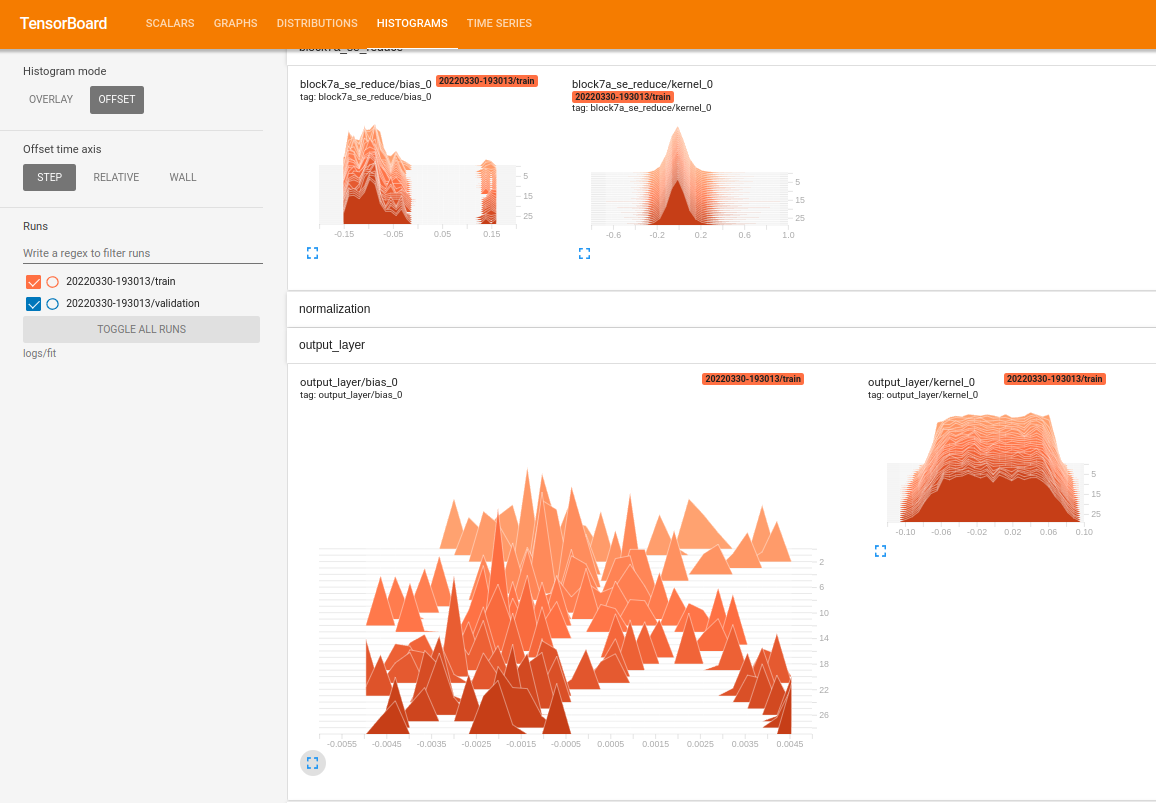

В тензорфлоу модель реализуется с помощью графа вычеслений, который автоматически строится и является неким черным ящиком, но благодаря чудесным функциям тенсорбоард мы можем его увидеть:)
# 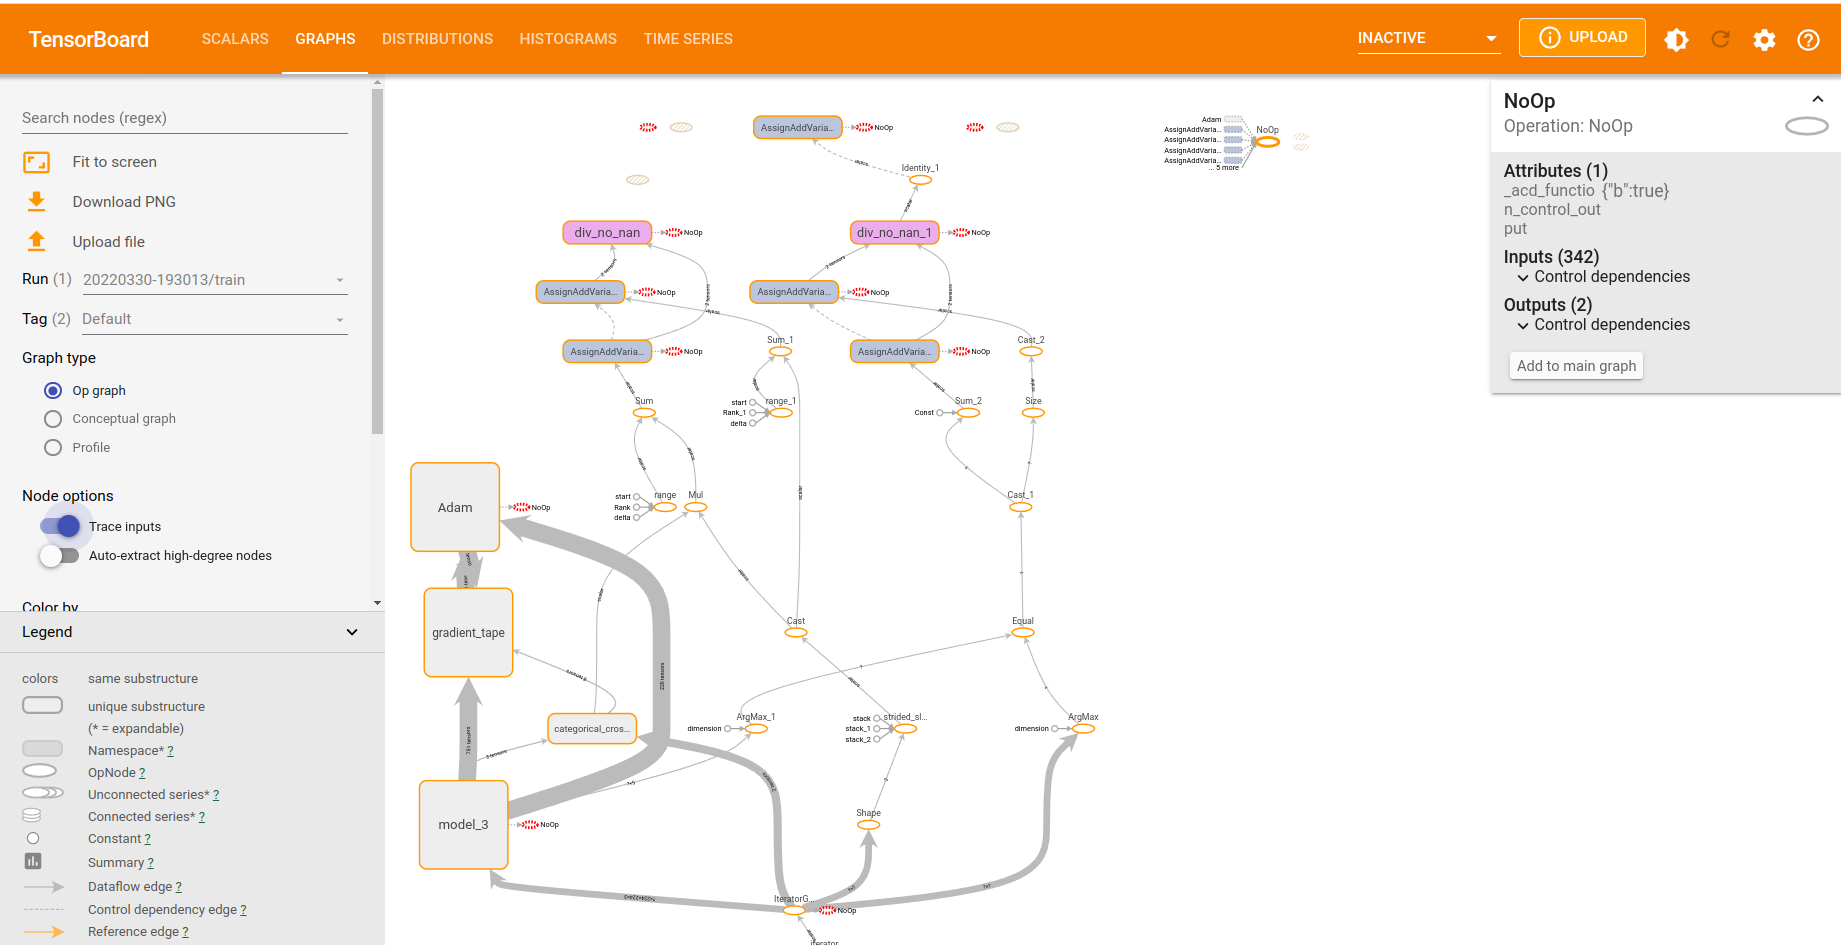


# 7 Получение предсказаний

In [145]:
def read_img(link):
    img = cv2.imread(link)
    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # resize to 224x224 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224))
    return img

In [146]:
def predictions_img(link = './data/test/2110.jpeg'):
    # read the image
    img = read_img(link)
    # add a batch dimension in front
    image = np.expand_dims(img, axis=0)
    predictions = model_unfreez.predict(image, verbose=1)
    return predictions

In [147]:
#При использовании функции актвации softmax на выходе модели получаем вектор из действительных чисел [0,1] 
predictions = predictions_img('./data/test/l3.jpeg')
predictions

1/1 [==============================] - 1s 677ms/step


array([[2.5819796e-03, 9.9222845e-01, 1.2835040e-04, 1.3505749e-04,
        4.9261125e-03]], dtype=float32)

In [148]:
# Трансформируем векторное представление в предсказанный класс
predict_class = CLASSES[np.argmax(predictions)]
predict_class

'land_cruiser'

In [151]:
# Ну и собственно исходное изображение с предсказанием
def show(link='./data/test/l4.jpeg'):
    img = cv2.imread(link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(predict_class)
    plt.show()

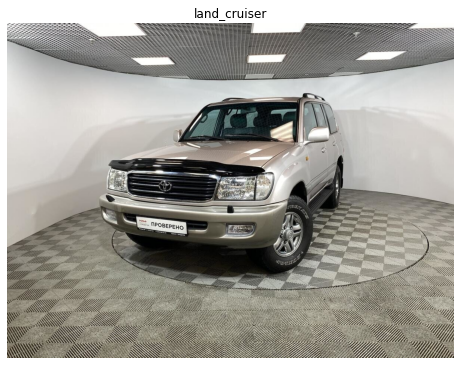

In [153]:
show('./data/test/l4.jpeg')

#  8 Корреляционная матрица

Вставить описание о кореляционнй матрице

In [154]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [155]:
# Переобразуем  валидационные данные из формата ImageDataGenerator в numpy массив. 
# это будет удобно для дальнейшего представления
val_images, val_labels = next(validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=45, shuffle=False))

Found 45 images belonging to 5 classes.


In [156]:
# Преобразуем выходы софтмакса в целевые значения
pred_probs = np.argmax(model_unfreez.predict(validation_generator, verbose=1), axis=1)
val_labels_true=np.argmax(val_labels, axis=1)

2/2 [==============================] - 1s 62ms/step


In [157]:
# Создадим корhеляционную матрицу
cm = confusion_matrix(y_true=val_labels_true, y_pred=pred_probs, normalize='true')
cm

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

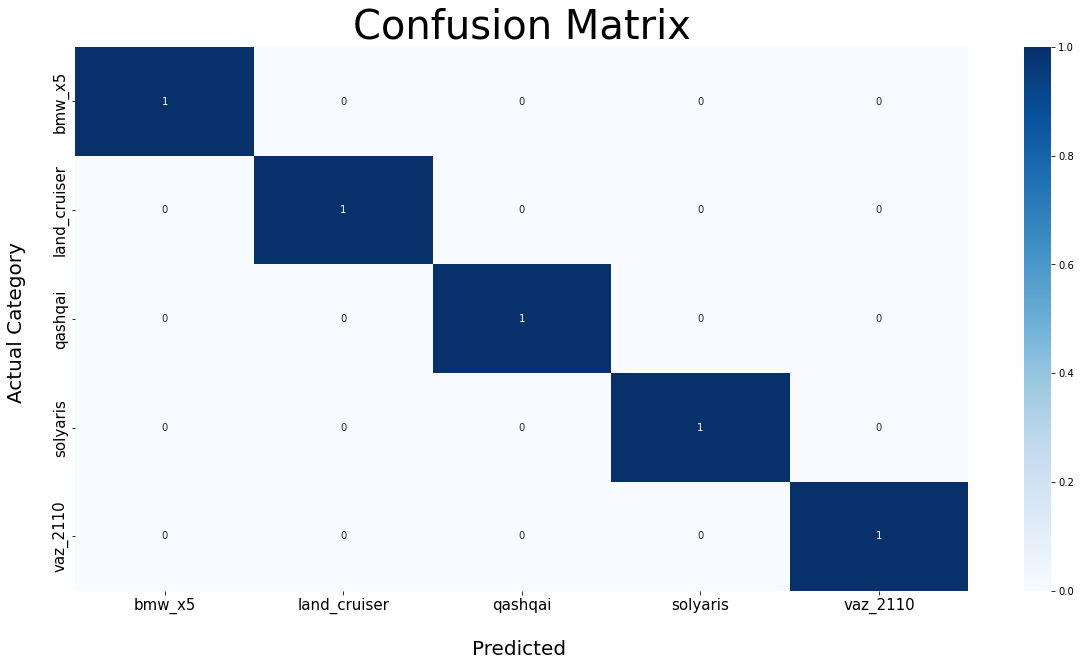

In [158]:
# Востпользуемся тепловым представлением  корреляционной матрицы с помощью бибилотеки seaborn\
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix',fontsize=40);
ax.set_xlabel('\nPredicted ',fontsize=20)
ax.set_ylabel('Actual Category \n',fontsize=20);

# Ярлыки значений
ax.xaxis.set_ticklabels(CLASSES,fontsize=15)
ax.yaxis.set_ticklabels(CLASSES,fontsize=15)

# Представление матрицы
plt.show()

С учетом того, что точность нашей модели равна 1 мы видим идеальный вариант кореляционной матрицы...

# 9 Saliency map

In [160]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img_expand(link):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 300x300 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [161]:
# ID класса  нашего изображения
class_index = CLASSES.index('land_cruiser')  #1

# Количество классов в обучающих данных модели
num_classes = 5
image_expand, img = read_img_expand(link='./data/test/l4.jpeg')
# Преоюрзуем в one hot представление, чтобы оно соответствовало нашей активации softmax в определении модели
expected_output = tf.one_hot([class_index] * image_expand.shape[0], num_classes)

with tf.GradientTape() as tape:
    # Преобразуем изображение во  float
    inputs = tf.cast(image_expand, tf.float32)

    # Посмотрим входные пиксели
    tape.watch(inputs)

    # Создадим предсказания
    predictions = model_unfreez(inputs)

    # Получим loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# Получим градиент относительно входных данных
gradients = tape.gradient(loss, inputs)

In [162]:
# Уменьшим изображение RGB до оттенков серого
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# Нормализуем значения пикселей градиента, чтобы они находились в диапазоне [0, 255].
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

#  Преобразуем в двумерный тензор
normalized_tensor = tf.squeeze(normalized_tensor)

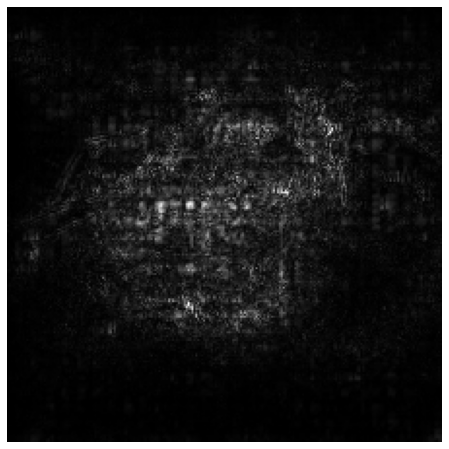

In [163]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()


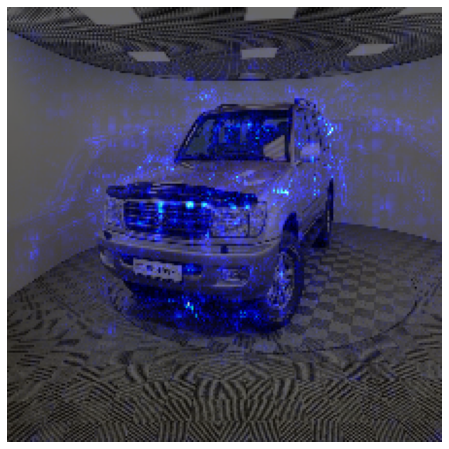

In [164]:
# Совместим исходное изображение с изображением градиента
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.8, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

# 10 Сохранение модели

In [ ]:
# Save the entire model as a models/model/1
MODEL_DIR = "models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)